In [179]:
import numpy as np 
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff

from category_encoders import TargetEncoder, BinaryEncoder

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 1. Выбрать и обосновать метрику для измерения качества

## Выбор метрики

По описанию датасета можно сделать вывод, что решить придется задачу бинарной классификации.

Для этих задач обычно используют несколько метрик - Accuracy, F1, AUC-ROC и др.
Прежде чем сделать выбор в пользу той или иной, необходимо посмотреть на значение целевой переменной.

In [ ]:
# Загружаем датасет
df = pd.read_csv("./final_depression_dataset_1.csv")
df.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


## Обоснование метрики

Посмотрим на распределение классов для целевой переменной.

In [181]:
class_counts = df['Depression'].value_counts()
total_counts = len(df)
(class_counts / total_counts) * 1

Depression
No     0.821987
Yes    0.178013
Name: count, dtype: float64

Из полученных значений видно, что наблюдается дисбаланс классов. Метрика accuracy в данном случае нам точно не подойдет. Можно сделать выбор в пользу F1 меры т.к. она хорошо подходит для датасетов с несбалансированной целевой переменной. 

# 2. Провести EDA на своих данных

## Базовые характеристики

Рассмотрим базовые характеристики датасета.  
Посмотрим размерность датасета и типы данных в столбцах.

In [182]:
print(df.shape)
df.dtypes

(2556, 19)


Name                                      object
Gender                                    object
Age                                        int64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                           int64
Financial Stress                           int64
Family History of Mental Illness          object
Depression                                object
dtype: object

Можно заметить, что датасет не очень большой. Есть определенное количество категориальных признаков, которые придется обработать в дальнейшем.

In [183]:
# Посмотрим на количество дубликатов
df.duplicated().sum()

0

Выделим целевую переменную. Разделим данные на численные и категориальные.

In [184]:
target_column=df["Depression"]
categorical_columns = df.select_dtypes(include=['object']).columns.drop(target_column.name)
numerical_columns = df.select_dtypes(exclude=['object']).columns

In [185]:
print("Categorical: ", categorical_columns.tolist())
print()
print("Numerical: ",numerical_columns.tolist())

Categorical:  ['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Numerical:  ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']


### Категориальные признаки

Выведем количество пропусков.

In [186]:
df[categorical_columns].isnull().sum()

Name                                       0
Gender                                     0
City                                       0
Working Professional or Student            0
Profession                               673
Sleep Duration                             0
Dietary Habits                             0
Degree                                     0
Have you ever had suicidal thoughts ?      0
Family History of Mental Illness           0
dtype: int64

Только Profession имеет пропуски. На данном этапе признак может считаться важным, поэтому не стоит его отбрасывать.  

Отобразим количество уникальных значений для каждого из категориального признака.

In [187]:
for column in categorical_columns:
    num_unique = df[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

'Name' has 216 unique categories.
'Gender' has 2 unique categories.
'City' has 30 unique categories.
'Working Professional or Student' has 2 unique categories.
'Profession' has 35 unique categories.
'Sleep Duration' has 4 unique categories.
'Dietary Habits' has 3 unique categories.
'Degree' has 27 unique categories.
'Have you ever had suicidal thoughts ?' has 2 unique categories.
'Family History of Mental Illness' has 2 unique categories.


Как видно, Name имеет высокую кардинальность. Она не достаточно полезная для предсказания модели, поэтому ее можно удалить или попробовать преобразовать.

City и Profession имеют среднюю кардинальность и могут являться достаточно полезными, поэтому стоит использовать правильное кодирование для этих признаков.

Sleep Duration, Dietary Habits и Degree являются ordinal категориями и должны быть закодированы с использованием ordinal encoding.

Признаки, содержащие только 2 уникальных значения являются бинарными и их легко можно закодировать. 

### Численные признаки

Отобразим сводную статистику по численным признакам. 

In [188]:
df[numerical_columns].isnull().sum()

Age                      0
Academic Pressure     2054
Work Pressure          502
CGPA                  2054
Study Satisfaction    2054
Job Satisfaction       502
Work/Study Hours         0
Financial Stress         0
dtype: int64

Наблюдаем большое количество данных с пропусками. Необходимо провести предобработку для них. Например, можно заполнить пропуски mean/median значениями.

In [189]:
df[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2556.0,39.043036,12.260596,18.00,28.00,39.000,50.000,60.0
Academic Pressure,502.0,3.003984,1.390007,1.00,2.00,3.000,4.000,5.0
Work Pressure,2054.0,3.021908,1.417312,1.00,2.00,3.000,4.000,5.0
CGPA,502.0,7.567809,1.465367,5.03,6.21,7.605,8.825,10.0
Study Satisfaction,502.0,3.075697,1.373490,1.00,2.00,3.000,4.000,5.0
Job Satisfaction,2054.0,3.015093,1.418432,1.00,2.00,3.000,4.000,5.0
Work/Study Hours,2556.0,6.023865,3.771743,0.00,3.00,6.000,9.000,12.0
Financial Stress,2556.0,2.968701,1.415527,1.00,2.00,3.000,4.000,5.0


Можно произвести нормализацию данных. Например, подойдет и StandardScaler, однако можно воспользоваться и MinMaxScaler.

## Визуализация

In [190]:
target_counts = target_column.value_counts()
fig = px.pie(values=target_counts, names=target_counts.index, title='Распределение риска депрессии')
fig.show(renderer='iframe')

In [191]:
gender_counts = df["Gender"].value_counts()
fig = px.pie(values=gender_counts, names=gender_counts.index, title='Распределение по полу')
fig.show(renderer='iframe')

In [192]:
fig = px.histogram(df, x='Gender', color='Depression', barmode='group', title='Распределение риска депрессии по полу')
fig.show(renderer='iframe')

In [193]:
fig = px.histogram(df, x='Age', color='Depression', barmode='group', title='Распределение риска депрессии по возрасту')
fig.show(renderer='iframe')

In [194]:
fig = px.histogram(df, x='City', color='Depression', barmode='group', title='Распределение риска депрессии по городу')
fig.show(renderer='iframe')

In [195]:
fig = px.histogram(df, x='Working Professional or Student', color='Depression', barmode='group', title='Распределение риска депрессии по виду занятости')
fig.show(renderer='iframe')

In [196]:
fig = px.histogram(df, x='Profession', color='Depression', barmode='group', title='Распределение риска депрессии по профессии')
fig.show(renderer='iframe')

In [197]:
fig = px.histogram(df, x='Academic Pressure', color='Depression', barmode='group', title='Распределение риска депрессии по академической загруженности')
fig.show(renderer='iframe')

In [198]:
fig = px.histogram(df, x='Work Pressure', color='Depression', barmode='group', title='Распределение риска депрессии по рабочей загруженности')
fig.show(renderer='iframe')

In [199]:
fig = px.histogram(df, x='CGPA', color='Depression', barmode='group', title='Распределение риска депрессии по оценкам')
fig.show(renderer='iframe')

In [200]:
fig = px.histogram(df, x='Study Satisfaction', color='Depression', barmode='group', title='Распределение риска депрессии по удовлетворенности в учебе')
fig.show(renderer='iframe')

In [201]:
fig = px.histogram(df, x='Job Satisfaction', color='Depression', barmode='group', title='Распределение риска депрессии по удовлетворенности в работе')
fig.show(renderer='iframe')

In [202]:
fig = px.histogram(df, x='Sleep Duration', color='Depression', barmode='group', title='Распределение риска депрессии по часам сна')
fig.show(renderer='iframe')

In [203]:
fig = px.histogram(df, x='Dietary Habits', color='Depression', barmode='group', title='Распределение риска депрессии по диете')
fig.show(renderer='iframe')

In [204]:
fig = px.histogram(df, x='Degree', color='Depression', barmode='group', title='Распределение риска депрессии по уровню образования')
fig.show(renderer='iframe')

In [205]:
fig = px.histogram(df, x='Have you ever had suicidal thoughts ?', color='Depression', barmode='group', title='Распределение риска депрессии по суицидальным мыслям')
fig.show(renderer='iframe')

In [206]:
fig = px.histogram(df, x='Family History of Mental Illness', color='Depression', barmode='group', title='Распределение риска депрессии по наследственным заболеваниям')
fig.show(renderer='iframe')

In [207]:
correlation_matrix = df.corr(numeric_only=True)
fig = px.imshow(correlation_matrix, 
                text_auto=True,
                color_continuous_scale='RdYlBu',
                title='Тепловая карта',
                aspect='auto')
fig.show(renderer='iframe')

Много низкокореллированных признаков. Пока сложно понять, хорошо это или плохо.

# 3. Построить и оценить качество бейзлайна

## Предобработка данных

Переименовываем столбцы и избавляемся от пробелов для простоты работы.

In [208]:
df.columns = [col.replace(' ', '_') for col in df.columns]
df.columns

Index(['Name', 'Gender', 'Age', 'City', 'Working_Professional_or_Student',
       'Profession', 'Academic_Pressure', 'Work_Pressure', 'CGPA',
       'Study_Satisfaction', 'Job_Satisfaction', 'Sleep_Duration',
       'Dietary_Habits', 'Degree', 'Have_you_ever_had_suicidal_thoughts_?',
       'Work/Study_Hours', 'Financial_Stress',
       'Family_History_of_Mental_Illness', 'Depression'],
      dtype='object')

Удаляем признак имени т.к. предполагаем, что риск депрессии не зависит от имени.

In [209]:
df.drop('Name', axis=1, inplace=True)

In [210]:
X = df.drop("Depression", axis=1)
y = df["Depression"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2024
)

Заполняем пропуски в полезных признаков нулями.

In [211]:
X_train.isna().sum()

Gender                                      0
Age                                         0
City                                        0
Working_Professional_or_Student             0
Profession                                553
Academic_Pressure                        1624
Work_Pressure                             420
CGPA                                     1624
Study_Satisfaction                       1624
Job_Satisfaction                          420
Sleep_Duration                              0
Dietary_Habits                              0
Degree                                      0
Have_you_ever_had_suicidal_thoughts_?       0
Work/Study_Hours                            0
Financial_Stress                            0
Family_History_of_Mental_Illness            0
dtype: int64

In [212]:
X_train.fillna({'Profession': 'Unknown'}, inplace=True)
X_test.fillna({'Profession': 'Unknown'}, inplace=True)

In [213]:
X_train.fillna({'Academic_Pressure': 0, 'Work_Pressure': 0, 'CGPA': 0, 'Study_Satisfaction': 0, 'Job_Satisfaction': 0}, inplace=True)
X_test.fillna({'Academic_Pressure': 0, 'Work_Pressure': 0, 'CGPA': 0, 'Study_Satisfaction': 0, 'Job_Satisfaction': 0}, inplace=True)

In [214]:
X_train.isna().sum()

Gender                                   0
Age                                      0
City                                     0
Working_Professional_or_Student          0
Profession                               0
Academic_Pressure                        0
Work_Pressure                            0
CGPA                                     0
Study_Satisfaction                       0
Job_Satisfaction                         0
Sleep_Duration                           0
Dietary_Habits                           0
Degree                                   0
Have_you_ever_had_suicidal_thoughts_?    0
Work/Study_Hours                         0
Financial_Stress                         0
Family_History_of_Mental_Illness         0
dtype: int64

Переводим категориальные признаки в порядковые и бинарные.

In [215]:
ord_enc = OrdinalEncoder()

X_train["Sleep_Duration"] = ord_enc.fit_transform(
    X_train["Sleep_Duration"].values.reshape(-1, 1)
)
X_test["Sleep_Duration"] = ord_enc.transform(
    X_test["Sleep_Duration"].values.reshape(-1, 1)
)

X_train["Dietary_Habits"] = ord_enc.fit_transform(
    X_train["Dietary_Habits"].values.reshape(-1, 1)
)
X_test["Dietary_Habits"] = ord_enc.transform(
    X_test["Dietary_Habits"].values.reshape(-1, 1)
)

In [216]:
binary_columns = ["Gender","Working_Professional_or_Student", "Have_you_ever_had_suicidal_thoughts_?", "Family_History_of_Mental_Illness"]

bin_enc = BinaryEncoder(cols=binary_columns)

X_train = bin_enc.fit_transform(X_train)
X_test = bin_enc.transform(X_test)

Кодируем целевую переменную при помощи LabelEncoder.

In [217]:
label_enc = LabelEncoder()

y_train = pd.Series(label_enc.fit_transform(y_train))
y_test = pd.Series(label_enc.transform(y_test))

Выполняем кодирование категориальных признаков с привязкой целевой переменной т.к. предполагаем, что они влияют на уровень депрессии.

In [218]:
target_encode_columns = ['Profession', 'Degree', 'City']

target_encoder = TargetEncoder(cols=target_encode_columns)

X_train[target_encode_columns] = target_encoder.fit_transform(X_train[target_encode_columns], y_train.values)
X_test[target_encode_columns] = target_encoder.transform(X_test[target_encode_columns])

Смотрим на полученные результаты предобработки данных.

In [219]:
print(X_train.dtypes, "\n\n", X_test.dtypes)

Gender_0                                     int64
Gender_1                                     int64
Age                                          int64
City                                       float64
Working_Professional_or_Student_0            int64
Working_Professional_or_Student_1            int64
Profession                                 float64
Academic_Pressure                          float64
Work_Pressure                              float64
CGPA                                       float64
Study_Satisfaction                         float64
Job_Satisfaction                           float64
Sleep_Duration                             float64
Dietary_Habits                             float64
Degree                                     float64
Have_you_ever_had_suicidal_thoughts_?_0      int64
Have_you_ever_had_suicidal_thoughts_?_1      int64
Work/Study_Hours                             int64
Financial_Stress                             int64
Family_History_of_Mental_Illnes

In [220]:
print(X_train.isnull().sum(), "\n\n", X_test.isnull().sum())

Gender_0                                   0
Gender_1                                   0
Age                                        0
City                                       0
Working_Professional_or_Student_0          0
Working_Professional_or_Student_1          0
Profession                                 0
Academic_Pressure                          0
Work_Pressure                              0
CGPA                                       0
Study_Satisfaction                         0
Job_Satisfaction                           0
Sleep_Duration                             0
Dietary_Habits                             0
Degree                                     0
Have_you_ever_had_suicidal_thoughts_?_0    0
Have_you_ever_had_suicidal_thoughts_?_1    0
Work/Study_Hours                           0
Financial_Stress                           0
Family_History_of_Mental_Illness_0         0
Family_History_of_Mental_Illness_1         0
dtype: int64 

 Gender_0                               

In [221]:
feature_labels=X_train.columns

## Константный предиктор

Составим константный предиктор по самому частому классу.

In [222]:
most_frequent_class = y_train.mode()[0]

In [223]:
y_pred_constant = np.full_like(y_test, fill_value=most_frequent_class)

In [224]:
f1_score(y_test, y_pred_constant)

0.0

Учитывая дисбаланс в наборе данных, постоянный предиктор предсказывает класс большинства "No" для всех случаев, что приводит к F1-Score, равному 0, для класса "Yes".

## Базовая модель

В качестве базовой модели построим логистическую регрессию.  
Для линейной модели необходимо произвести нормализацию данных.

In [225]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

В логистическую регрессию установим параметр class_weight в 'balanced' для правильной работы с несбалансированными классами.

In [226]:
baseline_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2024)
baseline_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2024)

In [227]:
y_pred = baseline_model.predict(X_test)

Произведем оценку качества получившийся модели с помощью f1 метрики.

In [228]:
f1_score(y_test, y_pred)

0.8834355828220859

Для визуализации результата работы модели воспользуемся матрицой ошибок. 

In [229]:
cm = confusion_matrix(y_test, y_pred)

fig = ff.create_annotated_heatmap(
    z=cm,
    x=['Predicted No', 'Predicted Yes'],
    y=['Actual No', 'Actual Yes'],
)
fig.update_layout(title='Матрица ошибок')
fig.show(renderer='iframe')

## Построить более сложную модель с подбором гиперпараметров

In [165]:
import optuna
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_auc_score

In [166]:
# Подбор гиперпараметров с использованием кросс-валидации 

def objective(trial):
    param = {
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0,4),
        'reg_alpha': trial.suggest_float('reg_alpha', 0,4),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 2024
    }

    model = xgb.XGBClassifier(**param)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc')
    return scores.mean()

f1_score не поддерживается напрямую в качестве eval_metric в XGBoost. Метрика AUC была выбрана для оценки модели, так как она устойчива к дисбалансу классов и предоставляет интуитивно понятную интерпретацию способности модели различать положительные и отрицательные классы. В отличие от метрики logloss, она позволяет более точно оценить общую производительность модели в задачах классификации с дисбалансом классов.

In [167]:
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=2024))
study.optimize(objective, n_trials=100)

In [168]:
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'max_depth': 2, 'learning_rate': 0.08173956905266634, 'n_estimators': 698, 'subsample': 0.5351014689543196, 'colsample_bytree': 0.6164499948348017, 'reg_lambda': 2.2785826695319766, 'reg_alpha': 1.8897997774028217, 'gamma': 0.17297780329352525, 'min_child_weight': 3}


In [169]:
fig = optuna.visualization.plot_param_importances(study)
fig.show(renderer='iframe')

In [170]:
# Обучение модели с лучшими гиперпараметрами

model = xgb.XGBClassifier(**best_params, random_state=2024)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6164499948348017, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.17297780329352525,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08173956905266634,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=698, n_jobs=None,
              num_parallel_tree=None, random_state=2024, ...)

In [171]:
# Оценка качества модели на отложенной выборке

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Вычисление F1 Score и AUC

f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score on test set: {f1}")
print(f"AUC on test set: {auc}")

F1 Score on test set: 0.8827586206896553
AUC on test set: 0.9953993055555554


## Интерпритация полученной модели

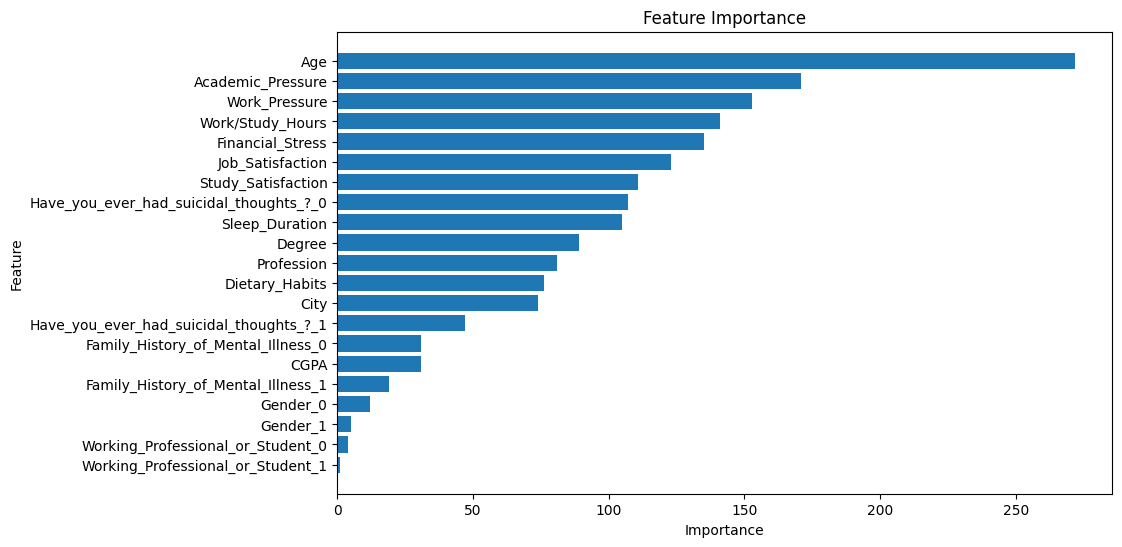

In [234]:
# Получение коэффициентов модели

booster = model.get_booster()
importance = booster.get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': list(feature_labels),
    'Importance': list(importance.values())
})

# Сортировка по важности

importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [231]:
# Матрица ошибок

cm = confusion_matrix(y_test, y_pred)

fig = ff.create_annotated_heatmap(
    z=cm,
    x=['Predicted No', 'Predicted Yes'],
    y=['Actual No', 'Actual Yes'],
)
fig.update_layout(title='Матрица ошибок')
fig.show(renderer='iframe')

In [235]:
import eli5
from eli5.sklearn import PermutationImportance

In [237]:
# Перестановочная важность признаков

perm = PermutationImportance(model, random_state=2024).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=list(feature_labels))

Weight,Feature
0.1121 ± 0.0127,Age
0.0488 ± 0.0070,Work_Pressure
0.0445 ± 0.0136,Have_you_ever_had_suicidal_thoughts_?_0
0.0422 ± 0.0068,Academic_Pressure
0.0320 ± 0.0077,Job_Satisfaction
0.0293 ± 0.0089,Financial_Stress
0.0223 ± 0.0098,Work/Study_Hours
0.0172 ± 0.0046,Study_Satisfaction
0.0145 ± 0.0072,Have_you_ever_had_suicidal_thoughts_?_1
0.0121 ± 0.0067,Dietary_Habits


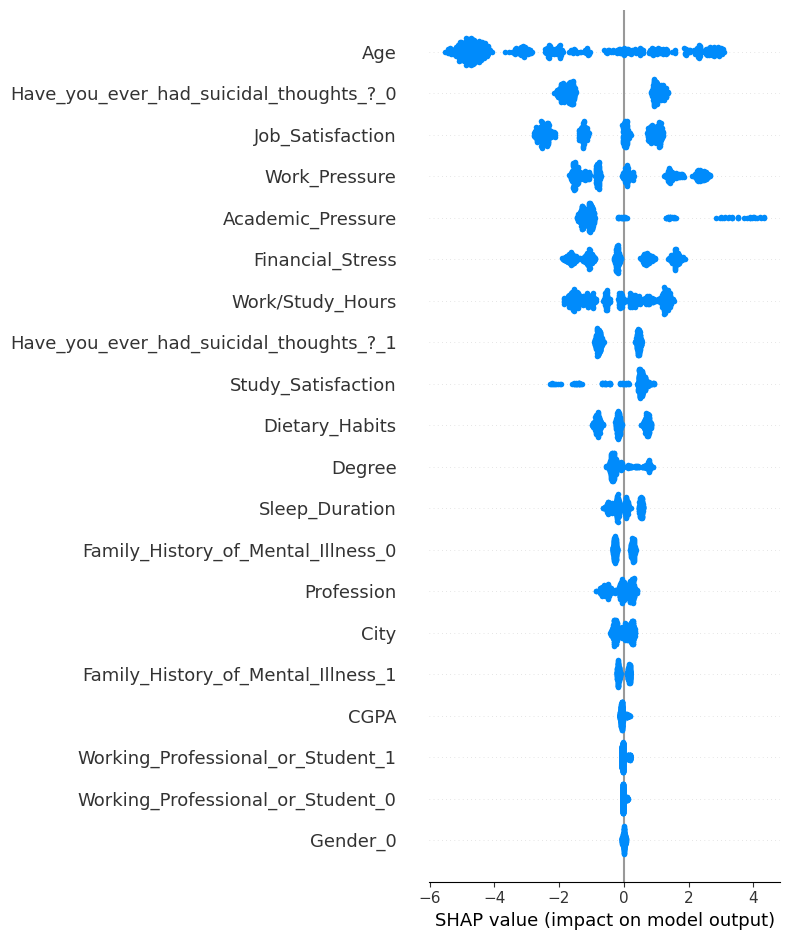

In [247]:
import shap

# Создание объяснителя SHAP

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Визуализация важности признаков с помощью SHAP

shap.summary_plot(shap_values, list(feature_labels))

На основе визуализаций важности признаков и интерпретации модели с использованием SHAP можно сделать вывод, что модель адекватно использует признаки для предсказания депрессии. Важные признаки, такие как возраст, давление на работе или учебе и баланс работы/учебы, оказывают значительное влияние на предсказания модели, что соответствует ожиданиям. Модель демонстрирует хорошую способность различать классы, что подтверждается высокими значениями метрик F1 Score и AUC. Однако улучшение от базовой модели при применении более сложной модели XGBoost оказалось незначительным по метрике F1, что может указывать на необходимость дальнейшего анализа и возможной оптимизации признаков или гиперпараметров.

Спасибо за внимание ❤